In [ ]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 77kB/s 
     |████████████████████████████████| 204kB 38.8MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=ddebcfe971a9d2bff6fe73f41f72a034765dfd525a0d4d7b4d0b850f16d69537
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
import os
import math
import shutil
from scipy.spatial import distance as spa
import sys
from operator import add
import itertools
import numpy as np
import random
import time as time
from pyspark import SparkContext
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

font = {'family' : 'Times New Roman',
        'size'   : 18}    
plt.rc('font', **font)

import matplotlib as mpl

In [ ]:
# initialize the spark context
sc = SparkContext(appName="Spark Apriori")

In [ ]:
path = "/content/drive/My Drive/data.txt"

data = np.genfromtxt(path)
n_examples, n_features = data.shape

kc = 10 # number of clusters
max_iterations = 20 # maximum number of iterations

In [ ]:
# import the data
data_rdd = sc.textFile(path,2)
# data_rdd = sc.parallelize(data,2)

# count the total number of baskets
print('Total number of examples = ', data_rdd.count())

datafloat = data_rdd.map(lambda line: ([float(item) for item in line.strip().split(' ')]))
datazipped = datafloat.zipWithIndex().map(lambda x: (x[1],x[0]))

for val in datazipped.take(2):
  print(val)

Total number of examples =  4601
(0, [0.0, 0.64, 0.64, 0.0, 0.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.64, 0.0, 0.0, 0.0, 0.32, 0.0, 1.29, 1.93, 0.0, 0.96, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.778, 0.0, 0.0, 3.756, 61.0, 278.0, 1.0])
(1, [0.21, 0.28, 0.5, 0.0, 0.14, 0.28, 0.21, 0.07, 0.0, 0.94, 0.21, 0.79, 0.65, 0.21, 0.14, 0.14, 0.07, 0.28, 3.47, 0.0, 1.59, 0.0, 0.43, 0.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.132, 0.0, 0.372, 0.18, 0.048, 5.114, 101.0, 1028.0, 1.0])


In [ ]:
def initialize_centroid(data, num_clusters):
  sample = sc.parallelize(data.takeSample(False, num_clusters))
  centroids = sample.map(lambda x : x[1])
  centroids = centroids.zipWithIndex().map(lambda x: (x[1],x[0]))
  return centroids

centroids = initialize_centroid(datazipped, kc)
for item in centroids.take(2):
  print(item)


(0, [0.0, 1.26, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.26, 0.0, 0.0, 1.26, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.416, 0.0, 0.0, 9.785, 42.0, 137.0, 1.0])
(1, [0.52, 0.42, 0.35, 0.0, 0.14, 0.03, 0.03, 0.1, 0.56, 0.8, 0.28, 0.7, 0.56, 1.19, 0.03, 0.24, 0.45, 0.0, 3.18, 0.0, 1.47, 0.0, 0.38, 0.63, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07, 0.0, 0.0, 0.0, 0.0, 0.075, 0.0, 0.452, 0.528, 0.116, 6.152, 260.0, 2184.0, 1.0])


In [ ]:
from scipy.spatial import distance
a = np.array([1, 0, 0])
b = np.array([0, 1, 0])
distance.euclidean(a, b)

1.4142135623730951

In [ ]:
def calculate_distance_euclidien(centroid, data_element):
    centroid_features = np.array(centroid[1])
    data_element_features = np.array(data_element[1])
    distance = spa.euclidean(centroid_features, data_element_features)
    return (data_element[0], (centroid[0], distance))

def calculate_distance_manhattan(centroid, data_element):
    centroid_features = np.array(centroid[1])
    data_element_features = np.array(data_element[1])
    distance = spa.cityblock(centroid_features, data_element_features)
    return (data_element[0], (centroid[0], distance))

def min_distance(row):
    element_index = row[0]
    centroids_distances_list = row[1]
    minimum_distance = -1
    closest_centroid = None
    min_centroid_index = -1
    for item in centroids_distances_list:
        centroid_index = item[0]
        distance = item[1]
        if (minimum_distance == -1) or (distance < minimum_distance):
            minimum_distance = distance
            min_centroid_index = centroid_index
            closest_centroid = (min_centroid_index, minimum_distance)
    return (element_index, closest_centroid)

def assign_cluster(centroids, data):
  centroids_data = centroids.cartesian(data)
  data_centroids_distances = centroids_data.map(lambda x: calculate_distance_euclidien(x[0], x[1]))
  data_assignedto_closest_cluster = data_centroids_distances.groupByKey().map(lambda x: (x[0], list(x[1]))).map(lambda x: min_distance(x))

  return data_assignedto_closest_cluster


In [ ]:
def compute_new_centroid(centroid_index, cluster_elements):
    all_cluster_elements = []
    for element in cluster_elements:
        # element = ([5.4, 3.7, 1.5, 0.2, u'Iris-setosa'], 0.6999999999999994)
        all_cluster_elements.append(element[0])
    averageArray = list(np.average(all_cluster_elements, axis = 0))
    new_centroid = (centroid_index, averageArray)
    return new_centroid

def compute_new_centroids(dataMinDistance):
  dataByCluster = dataMinDistance.join(datazipped).map(lambda x: (x[1][0][0], (x[1][1], x[1][0][1])))
  dataByCluster = dataByCluster.groupByKey().map(lambda x: (x[0], list(x[1])))
  newCentroids = dataByCluster.map(lambda x: compute_new_centroid(x[0], x[1]))    
  return newCentroids


In [ ]:
def compute_intracluster_distance(data):
  assigned_clusters = data.map(lambda x : x[1])
  average_distance_clsuter = assigned_clusters.map(lambda x: (x[0],(x[1],1))).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))
  average_distance_clsuter = average_distance_clsuter.map(lambda x: x[1][0]/x[1][1])
  result = average_distance_clsuter.sum()
  return result

In [ ]:
iterations = 0
results = np.zeros((max_iterations,3))
start = time.time()
while iterations < max_iterations:
  iterations += 1

  # assign each data element to closest cluster
  data_assignedto_closest_cluster =  assign_cluster(centroids, datazipped)

  # compute new centroid
  new_centroids = compute_new_centroids(data_assignedto_closest_cluster)

  # compute average intracluster distance 
  intra_cluster_distance = compute_intracluster_distance(data_assignedto_closest_cluster)
  
  # compute normalized cost function
  assigned_clusters = data_assignedto_closest_cluster.map(lambda x : x[1][1])
  cost = assigned_clusters.sum()/n_examples

  # print the cost function
  print('iteration # %.1d : %.3f' %(iterations, cost))

  # store the cost function for plotting
  results[iterations-1,:] = np.array([iterations, intra_cluster_distance, cost])

  # update centroid with the new centroid
  centroids = sc.parallelize(new_centroids.collect())

print('Total CPU time = %.3f' %(time.time() - start))


iteration # 1 : 72.058
iteration # 2 : 71.948
iteration # 3 : 71.846
iteration # 4 : 71.881
iteration # 5 : 71.926
iteration # 6 : 71.873
iteration # 7 : 71.852
iteration # 8 : 71.846
iteration # 9 : 71.752
iteration # 10 : 71.641
iteration # 11 : 71.566
iteration # 12 : 71.626
iteration # 13 : 71.557
iteration # 14 : 71.514
iteration # 15 : 71.486
iteration # 16 : 71.420
iteration # 17 : 71.335
iteration # 18 : 71.186
iteration # 19 : 71.041
iteration # 20 : 70.981
Total CPU time = 55.384


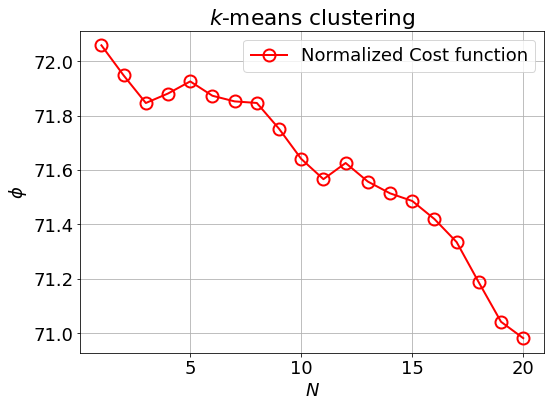

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(8,6))

axs.plot(results[:,0], results[:,2], 'ro-', lw=2, ms=12, mew=2, fillstyle='none',  label='Normalized Cost function')
# axs[0].plot(results[:,0], results[:,1], 'bo-', label='Intra-cluster distance')

axs.grid()
axs.set_xlabel('$N$')
axs.set_ylabel('$\phi$')
axs.legend(loc=0)
# axs[0].set_ylim(1e-8,1e0)
axs.set_title('$k$-means clustering')

fig.tight_layout()
plt.show()

